In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
#define path
radiomics_path = "D:\work\ingham-medphys-coding-master\ingham-medphys-coding-master\data\HN_Radiomics.csv"
clinical_data_path = "D:\work\ingham-medphys-coding-master\ingham-medphys-coding-master\data\HN_ClinicalData.csv"

In [3]:
#read data into dataframe
df_clinical_data=pd.read_csv(clinical_data_path)
df_radiomics=pd.read_csv(radiomics_path)

In [4]:
#attact GTV data
df_gtv_radiomics = df_radiomics[df_radiomics["Structure"].str.startswith("GTV")]
df_gtv_radiomics = df_gtv_radiomics.groupby("id")[["VoxelVolume", "SurfaceArea"]].sum()

In [5]:
#merge data into the clininal data
df = df_clinical_data.merge(df_gtv_radiomics, on="id")

In [7]:
Train_Data=df[df["dataset"]=="train"]
Test_Data=df[df["dataset"]=="test"]


In [8]:
#null data processing
df_Train_Data = Train_Data.drop(['overall_hpv_p16_status', 'pretreat_hb_in_mmolperlitre'],axis=1)
df_Test_Data = Test_Data.drop(['overall_hpv_p16_status', 'pretreat_hb_in_mmolperlitre'],axis=1)
df_Train_Data['performance_status_ecog'].fillna(df_Train_Data['performance_status_ecog'].value_counts().index[0], inplace=True)
df_Test_Data['performance_status_ecog'].fillna(df_Test_Data['performance_status_ecog'].value_counts().index[0], inplace=True)

In [9]:
#transform category data into numberic data
#index_tumour_location, 
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
cols = ('index_tumour_location', 'biological_sex', 'ajcc_stage', 'cancer_surgery_performed', 'chemotherapy_given')
# process columns, apply LabelEncoder to categorical features into numeric data
for c in cols:
    df_Train_Data[c] = labelencoder.fit_transform(df_Train_Data[c])
    df_Test_Data[c] = labelencoder.fit_transform(df_Test_Data[c])

In [42]:
x_train = df_Train_Data.drop(['id', 'dataset', 'overall_survival_in_days'], axis=1)
Y_train = df_Train_Data["overall_survival_in_days"]
x = x_train.values
y = Y_train.values

In [43]:
x_test = df_Test_Data.drop(['id', 'dataset', 'overall_survival_in_days'], axis=1)
Y_test = df_Test_Data["overall_survival_in_days"]

In [48]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(x_train)
y_train = sc_y.fit_transform(y.reshape(-1,1))
scaled_x_train = pd.DataFrame(X_train , index=x_train.index, columns=x_train.columns)
scaled_y_train = pd.DataFrame(y_train , index=Y_train.index, columns=["overall_survival_in_days"])
X_test = sc_X.transform(x_test)
scaled_x_test = pd.DataFrame(X_test , index=x_test.index, columns=x_test.columns)
#y_train = sc_y.transform(Y_train.reshape(-1,1))
#y_scaled = sc_y.fit_transform(y.reshape(-1,1))
#X_train,X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33, random_state=42)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\python\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by Sta

In [34]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

In [76]:
lasso =  Lasso(alpha =0.0005, random_state=1)
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
Random=RandomForestRegressor(n_estimators=400)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [23]:
def regression_model(model, data, x_train, Y_train):
  #Fit the model:
  model.fit(x_train,Y_train)
  
  #Make predictions on training set:
  predictions = model.predict(x_train)
  

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(n_splits=5).split(data)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (x_train.iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = Y_train.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(x_train.iloc[test,:], Y_train.iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Fit the model again so that it can be refered outside the function:
  model.fit(x_train,Y_train) 

In [67]:
regression_model(GBoost,df_Train_Data,x_train,Y_train)
GBoost_predictions = GBoost.predict(x_test).astype(int)
#test_prediction =sc_y.inverse_transform(predictions)
np.mean(GBoost_predictions-Y_test)

Cross-Validation Score : 80.249%
Cross-Validation Score : 79.059%
Cross-Validation Score : 78.400%
Cross-Validation Score : 78.468%
Cross-Validation Score : 77.161%


26.514285714285716

In [70]:
regression_model(Random,df_Train_Data,x_train,Y_train)
Random_predictions = Random.predict(x_test).astype(int)
#test_prediction =sc_y.inverse_transform(predictions)
np.mean(Random_predictions-Y_test)

Cross-Validation Score : 80.978%
Cross-Validation Score : 80.775%
Cross-Validation Score : 82.349%
Cross-Validation Score : 82.776%
Cross-Validation Score : 82.085%


-75.05714285714286

In [71]:
regression_model(ENet,df_Train_Data,x_train,Y_train)
ENet_predictions = ENet.predict(x_test).astype(int)
#test_prediction =sc_y.inverse_transform(predictions)
np.mean(ENet_predictions-Y_test)

Cross-Validation Score : 82.140%
Cross-Validation Score : 82.114%
Cross-Validation Score : 74.944%
Cross-Validation Score : 77.253%
Cross-Validation Score : 74.220%


d:\app\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data wi

-184.8

In [59]:
regression_model(model_xgb,df_Train_Data,x_train,Y_train)
xbg_predictions = model_xgb.predict(x_test).astype(int)
#test_prediction =sc_y.inverse_transform(predictions)
np.mean(xbg_predictions-Y_test)

d:\app\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\app\python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Cross-Validation Score : 75.936%


d:\app\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-Validation Score : 77.784%


d:\app\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-Validation Score : 77.650%


d:\app\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-Validation Score : 78.061%


d:\app\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-Validation Score : 76.767%


d:\app\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\app\python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


-28.231126621791294

In [56]:
print(predictions)

[3500.1414  1943.0269  3251.6602  3535.456    146.89313 2170.559
 3383.221   3377.4119   205.57509 3038.0269  2108.4685  3546.0657
 3587.1807  2810.1377   722.56854 3017.2654  4192.949   2247.7769
 3281.553   2884.4094  2200.1375  2202.9985  3218.157   3297.5896
 1295.3696  2187.9397   327.44058 1363.0574  3375.7046  3759.195
  441.6245  1862.1974  3011.9724  2954.0332  3521.1472 ]


In [57]:
print(Y_test)

1      2805
13     1164
16     3128
21     3925
22      103
25     2778
31     3904
32     3093
33      194
41     2599
42     2331
43     4734
48     3254
50     2972
51      595
53     1998
55     4789
65     1172
67     1411
68     3667
69     2545
77     1594
78     4572
82     3471
84     2505
85     1171
86       48
91     2455
98     3366
109    2910
113     424
115    3084
123    2824
124    2999
133    4373
Name: overall_survival_in_days, dtype: int64


In [72]:
prediction = pd.DataFrame(GBoost_predictions, columns=['overall_survival_in_days'])
result = pd.concat([ df_Test_Data['id'], prediction], axis=1)
result.to_csv('./Predictions.csv', index=False)

Text(0.5, 1.0, 'test_results_overall_survival_in_days')

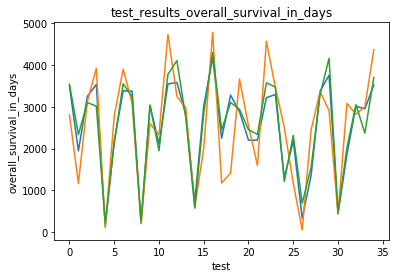

In [69]:
import matplotlib.pyplot as plt
x = np.arange(len(df_Test_Data['id']))
y1= xbg_predictions
y2= Y_test
y3=GBoost_predictions
plt.plot(x, y1, label = "XGBRegression")
plt.plot(x, y2, label = "test")
plt.plot(x, y3, label = "GBoot")
plt.xlabel('test')
plt.ylabel('overall_survival_in_days')
plt.title('test_results_overall_survival_in_days')

In [73]:
x_train_re = df_Train_Data.drop(['id', 'dataset', 'overall_survival_in_days','recurrence_metastatic_free_survival_in_days'], axis=1)
Y_train_re = df_Train_Data['recurrence_metastatic_free_survival_in_days']
x = x_train_re.values
y = Y_train_re.values

In [74]:
x_test_re = df_Test_Data.drop(['id', 'dataset', 'overall_survival_in_days','recurrence_metastatic_free_survival_in_days'], axis=1)
Y_test_re = df_Test_Data["recurrence_metastatic_free_survival_in_days"]


d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\python\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by Sta

In [77]:
regression_model(GBoost,df_Train_Data,x_train_re,Y_train_re)
GBoost_predictions_re = GBoost.predict(x_test_re).astype(int)
#test_prediction =sc_y.inverse_transform(predictions)
np.mean(GBoost_predictions_re-Y_test_re)

Cross-Validation Score : 92.590%
Cross-Validation Score : 93.470%
Cross-Validation Score : 94.462%
Cross-Validation Score : 94.903%
Cross-Validation Score : 93.517%


-76.68571428571428

Text(0.5, 1.0, 'recurrence_metastatic_free_survival_in_days')

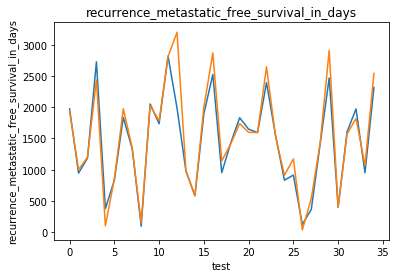

In [81]:
x = np.arange(len(df_Test_Data['id']))
y1= GBoost_predictions_re
y2= Y_test_re
plt.plot(x, y1, label = "GBOOtRegression")
plt.plot(x, y2, label = "test")
plt.xlabel('test')
plt.ylabel('recurrence_metastatic_free_survival_in_days')
plt.title('recurrence_metastatic_free_survival_in_days')